In [1]:
import os
import scipy.misc
import numpy as np

from forward_model import DCGAN
from utils import pp, visualize, to_json, show_all_variables

import tensorflow as tf

from glob import glob
from ops import *
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# flags
flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_integer("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 108, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", None, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 64, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", None, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "celebA", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples", "Directory name to save the image samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", True, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
FLAGS = flags.FLAGS

pp.pprint(flags.FLAGS.__flags)

if FLAGS.input_width is None:
    FLAGS.input_width = FLAGS.input_height
if FLAGS.output_width is None:
    FLAGS.output_width = FLAGS.output_height

if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)
if not os.path.exists(FLAGS.sample_dir):
    os.makedirs(FLAGS.sample_dir)

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

{}


In [3]:
data = glob("./data/celebA/*.jpg")


sample_files = data[0:64] #change to 64 images
sample = [get_image(sample_file,
                    input_height=108,
                    input_width=None,
                    resize_height=64,
                    resize_width=64,
                    crop=True,
                    grayscale=False) for sample_file in sample_files]

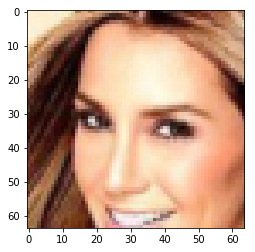

In [4]:
plt.imshow((sample[0] + 1.0)/2.0)
plt.show()

In [5]:
v = np.reshape(sample, (64, 64*64*3))
# number of features per image (pixels including all channels)
print('shape of v: {}'.format(v.shape))


n = v.shape[1]

shape of v: (64, 12288)


In [6]:
# this is compressed sensing setting
m = 1000
A = np.random.randn(n, m).astype('float32')
A = A / np.sqrt( np.sum( A**2, axis = 1 ) )[:,None]
y = np.dot(v, A) 

# this is full image included setting
# m = n 
print('number of measurements = {}'.format(m))
# y = v

number of measurements = 1000


In [7]:
# y_placeholder = tf.placeholder(tf.float32,[None,m])

# this loss is when we are doing compressed sensing
# our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2, 1)) 

# this loss is when we are taking image as measurement
# our_loss = tf.reduce_mean( tf.reduce_sum( (tf.reshape(dcgan.G, [64, -1]) - y_placeholder)**2, 1)) 

In [8]:
y.shape

(64, 1000)

In [9]:
#grad = tf.gradients(our_loss, dcgan.z)
#z_0 = np.random.uniform(-0.5, 0.5, size=(64 , 100))
count = 0

errs = []
    
    
with tf.Session() as sess:
    
    print(tf.global_variables())
    
    dcgan = DCGAN(
        sess,
        input_width=FLAGS.input_width,
        input_height=FLAGS.input_height,
        output_width=FLAGS.output_width,
        output_height=FLAGS.output_height,
        batch_size=FLAGS.batch_size,
        sample_num=FLAGS.batch_size,
        dataset_name=FLAGS.dataset,
        input_fname_pattern=FLAGS.input_fname_pattern,
        crop=FLAGS.crop,
        checkpoint_dir=FLAGS.checkpoint_dir,
        sample_dir=FLAGS.sample_dir)
    
    

    if not dcgan.load(FLAGS.checkpoint_dir)[0]:
        raise Exception("[!] Train a model first, then run test mode")
    
    dcgan.z.initializer.run()
    
    y_placeholder = tf.placeholder(tf.float32,[None,m])
    
    # -----------------------------------
    # use this if we are not using A
    # our_loss = tf.reduce_mean( tf.reduce_sum( (tf.reshape(dcgan.G, [64, -1]) - y_placeholder)**2, 1)) 
    # use this if we are using A
    our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2, 1)) 
    # -----------------------------------
    
    z_optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(our_loss, var_list=dcgan.z)  
    
#     show_all_variables()
    
    
    opt_initializers   = [var.initializer for var in tf.global_variables() if 'Adam' in var.name]
    beta1_initializers = [var.initializer for var in tf.global_variables() if 'beta1_power' in var.name]
    beta2_initializers = [var.initializer for var in tf.global_variables() if 'beta2_power' in var.name]
    
    sess.run(opt_initializers)
    sess.run(beta1_initializers)
    sess.run(beta2_initializers)

    
    for i in range(1000): # run until error stops decreasing or reaches threshhold, then print result at that point
        print('iteration {}'.format(count))
        a, closs, b = sess.run([z_optim, our_loss, dcgan.G],feed_dict={y_placeholder: y})
        count += 1
        print(closs)
        errs.append(closs)
        #z_0 = z_0 - rate*a[0]
    

[]
 [*] Reading checkpoints...
Instructions for updating:
Please use tf.global_variables instead.
z:0
generator/g_h0_lin/Matrix:0
generator/g_h0_lin/bias:0
generator/g_bn0/beta:0
generator/g_bn0/gamma:0
generator/g_bn0/moving_mean:0
generator/g_bn0/moving_variance:0
generator/g_h1/w:0
generator/g_h1/biases:0
generator/g_bn1/beta:0
generator/g_bn1/gamma:0
generator/g_bn1/moving_mean:0
generator/g_bn1/moving_variance:0
generator/g_h2/w:0
generator/g_h2/biases:0
generator/g_bn2/beta:0
generator/g_bn2/gamma:0
generator/g_bn2/moving_mean:0
generator/g_bn2/moving_variance:0
generator/g_h3/w:0
generator/g_h3/biases:0
generator/g_bn3/beta:0
generator/g_bn3/gamma:0
generator/g_bn3/moving_mean:0
generator/g_bn3/moving_variance:0
generator/g_h4/w:0
generator/g_h4/biases:0
discriminator/d_h0_conv/w:0
discriminator/d_h0_conv/biases:0
discriminator/d_h1_conv/w:0
discriminator/d_h1_conv/biases:0
discriminator/d_bn1/beta:0
discriminator/d_bn1/gamma:0
discriminator/d_bn1/moving_mean:0
discriminator/d_b

344.954
iteration 286
344.354
iteration 287
344.166
iteration 288
344.058
iteration 289
343.447
iteration 290
342.773
iteration 291
342.552
iteration 292
342.068
iteration 293
341.611
iteration 294
341.464
iteration 295
341.499
iteration 296
340.892
iteration 297
341.949
iteration 298
340.071
iteration 299
339.079
iteration 300
338.66
iteration 301
338.018
iteration 302
337.504
iteration 303
337.174
iteration 304
336.441
iteration 305
337.085
iteration 306
336.28
iteration 307
337.443
iteration 308
335.347
iteration 309
334.884
iteration 310
334.8
iteration 311
334.278
iteration 312
334.557
iteration 313
334.334
iteration 314
333.035
iteration 315
333.636
iteration 316
331.986
iteration 317
333.446
iteration 318
331.933
iteration 319
330.818
iteration 320
331.088
iteration 321
331.216
iteration 322
329.984
iteration 323
329.56
iteration 324
330.294
iteration 325
328.677
iteration 326
328.126
iteration 327
327.481
iteration 328
326.833
iteration 329
326.35
iteration 330
326.044
iteratio

268.696
iteration 661
268.971
iteration 662
268.453
iteration 663
268.368
iteration 664
268.719
iteration 665
268.57
iteration 666
268.644
iteration 667
268.131
iteration 668
268.472
iteration 669
268.064
iteration 670
268.457
iteration 671
268.32
iteration 672
267.882
iteration 673
267.682
iteration 674
267.546
iteration 675
267.204
iteration 676
267.11
iteration 677
267.198
iteration 678
267.18
iteration 679
266.525
iteration 680
266.851
iteration 681
266.495
iteration 682
266.158
iteration 683
266.157
iteration 684
265.792
iteration 685
266.057
iteration 686
266.079
iteration 687
266.386
iteration 688
266.265
iteration 689
266.109
iteration 690
266.241
iteration 691
266.402
iteration 692
265.494
iteration 693
265.491
iteration 694
265.493
iteration 695
265.003
iteration 696
265.258
iteration 697
264.934
iteration 698
265.533
iteration 699
264.711
iteration 700
264.991
iteration 701
264.896
iteration 702
264.623
iteration 703
265.269
iteration 704
266.466
iteration 705
265.808
iterat

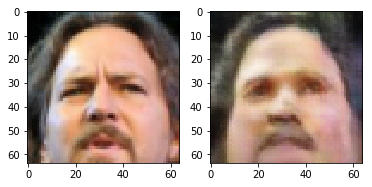

In [30]:
chosen_image = 19

fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.imshow((sample[chosen_image]+1.0)/2)

ax2 = fig.add_subplot(122)
ax2.imshow((b[chosen_image]+1.0)/2)
plt.show()

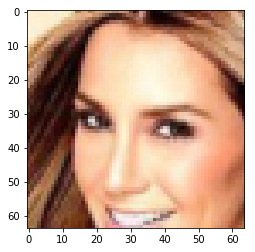

 [*] Reading checkpoints...
Instructions for updating:
Please use tf.global_variables instead.
z:0
generator/g_h0_lin/Matrix:0
generator/g_h0_lin/bias:0
generator/g_bn0/beta:0
generator/g_bn0/gamma:0
generator/g_bn0/moving_mean:0
generator/g_bn0/moving_variance:0
generator/g_h1/w:0
generator/g_h1/biases:0
generator/g_bn1/beta:0
generator/g_bn1/gamma:0
generator/g_bn1/moving_mean:0
generator/g_bn1/moving_variance:0
generator/g_h2/w:0
generator/g_h2/biases:0
generator/g_bn2/beta:0
generator/g_bn2/gamma:0
generator/g_bn2/moving_mean:0
generator/g_bn2/moving_variance:0
generator/g_h3/w:0
generator/g_h3/biases:0
generator/g_bn3/beta:0
generator/g_bn3/gamma:0
generator/g_bn3/moving_mean:0
generator/g_bn3/moving_variance:0
generator/g_h4/w:0
generator/g_h4/biases:0
discriminator/d_h0_conv/w:0
discriminator/d_h0_conv/biases:0
discriminator/d_h1_conv/w:0
discriminator/d_h1_conv/biases:0
discriminator/d_bn1/beta:0
discriminator/d_bn1/gamma:0
discriminator/d_bn1/moving_mean:0
discriminator/d_bn1/

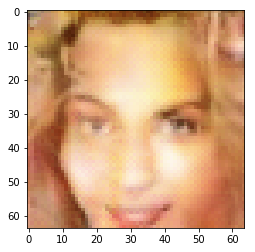

number of measurements = 100
iteration 0
2088.7
iteration 1
1775.79
iteration 2
1549.91
iteration 3
1414.25
iteration 4
1313.92


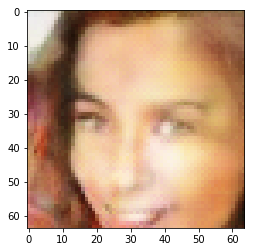

number of measurements = 200
iteration 0
1581.93
iteration 1
1402.12
iteration 2
1255.97
iteration 3
1173.21
iteration 4
1123.72


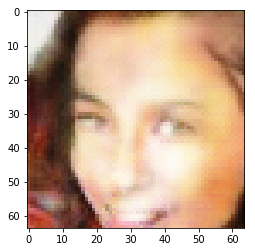

number of measurements = 500
iteration 0
1247.54
iteration 1
1220.73
iteration 2
1116.0
iteration 3
1058.82
iteration 4
1026.18


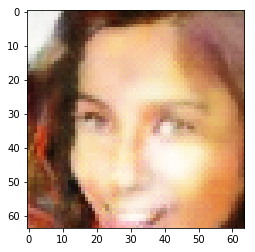

number of measurements = 1000
iteration 0
1006.09
iteration 1
1052.26
iteration 2
943.54
iteration 3
891.72
iteration 4
869.745


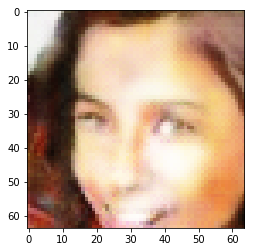

number of measurements = 2500
iteration 0
880.768
iteration 1
941.908
iteration 2
855.784
iteration 3
820.925
iteration 4
809.772


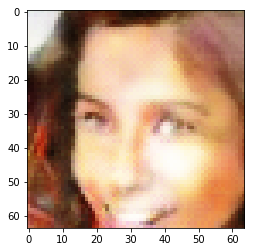

number of measurements = 5000
iteration 0
782.606
iteration 1
855.468
iteration 2
774.131
iteration 3
747.528
iteration 4
728.126


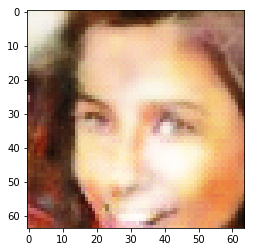

number of measurements = 7500
iteration 0
719.376
iteration 1
819.106
iteration 2
763.082
iteration 3
718.058
iteration 4
700.687


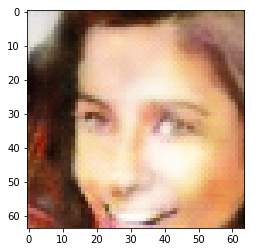

number of measurements = 10000
iteration 0
703.564
iteration 1
797.455
iteration 2
744.56
iteration 3
694.914
iteration 4
675.609


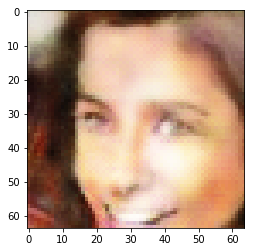

In [6]:
possible_ms = [12288, 50, 100, 200, 500, 1000, 2500, 5000, 7500, 10000]
num_iter = 4000
compressed_images = []

plt.imshow((sample[0] + 1.0)/2.0)
compressed_images.append((sample[0] + 1.0)/2.0)
plt.show()


with tf.Session() as sess:

    #print(tf.global_variables())

    dcgan = DCGAN(
        sess,
        input_width=FLAGS.input_width,
        input_height=FLAGS.input_height,
        output_width=FLAGS.output_width,
        output_height=FLAGS.output_height,
        batch_size=FLAGS.batch_size,
        sample_num=FLAGS.batch_size,
        dataset_name=FLAGS.dataset,
        input_fname_pattern=FLAGS.input_fname_pattern,
        crop=FLAGS.crop,
        checkpoint_dir=FLAGS.checkpoint_dir,
        sample_dir=FLAGS.sample_dir)



    if not dcgan.load(FLAGS.checkpoint_dir)[0]:
        raise Exception("[!] Train a model first, then run test mode")

    dcgan.z.initializer.run()

    for m in possible_ms:
        A = np.random.randn(n, m).astype('float32')
        A = A / np.sqrt( np.sum( A**2, axis = 1 ) )[:,None]
        y = np.dot(v, A) 

        print('number of measurements = {}'.format(m))
        count = 0
        y_placeholder = tf.placeholder(tf.float32,[None,m])

        # -----------------------------------
        our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2, 1)) 
        # -----------------------------------

        z_optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(our_loss, var_list=dcgan.z)  

        opt_initializers   = [var.initializer for var in tf.global_variables() if 'Adam' in var.name]
        beta1_initializers = [var.initializer for var in tf.global_variables() if 'beta1_power' in var.name]
        beta2_initializers = [var.initializer for var in tf.global_variables() if 'beta2_power' in var.name]

        sess.run(opt_initializers)
        sess.run(beta1_initializers)
        sess.run(beta2_initializers)


        for i in range(num_iter): # run until error stops decreasing or reaches threshhold, then print result at that point
            print('iteration {}'.format(count))
            a, closs, b = sess.run([z_optim, our_loss, dcgan.G],feed_dict={y_placeholder: y})
            count += 1
            print(closs)
        plt.imshow((b[0] + 1.0)/2.0)
        compressed_images.append((b[0] + 1.0)/2.0)
        plt.show()

    

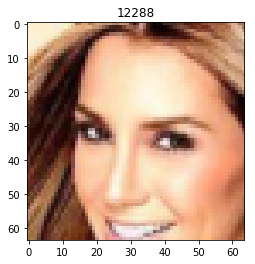

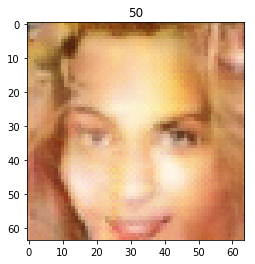

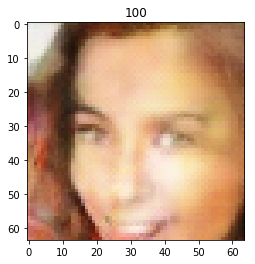

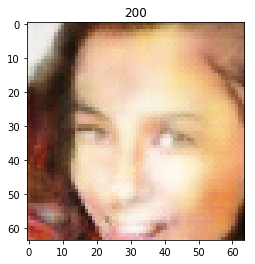

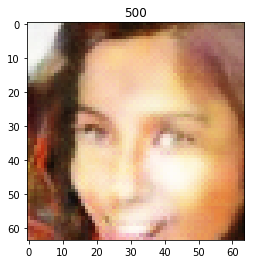

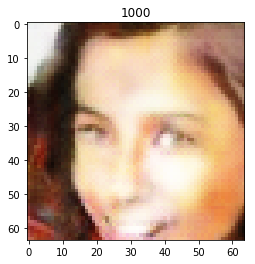

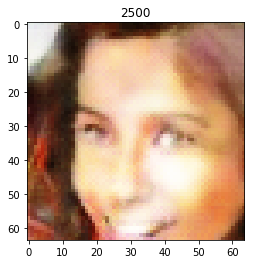

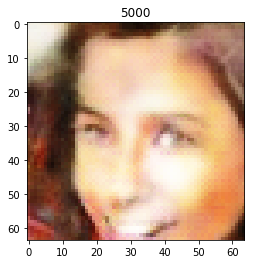

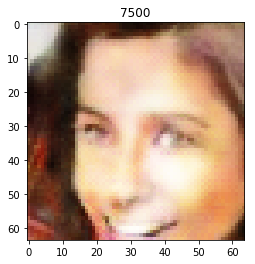

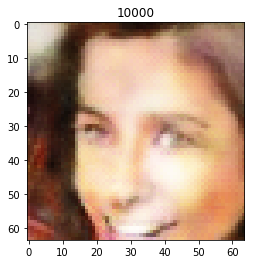

In [11]:
for i in range(len(compressed_images)):
    plt.figure()
    plt.title(possible_ms[i])
    plt.imshow(compressed_images[i])